# NYC Taxi Trip Duration Prediction
***
<img src='https://i.imgur.com/GNbWoOk.jpg' align="left"/>

## Table of Contents
***

### [Problem Statement](#problem)
 - [Set path](#path)
 - [Libraries](#library)
 - [Dataset](#data)
 - [Explore Data](#explore)

### [Univariate Analysis](#univariate)
 - [Passengers](#passenger)
 - [Vendor](#vendor)
 - [Distance](#distance)
 - [Trip duration](#duration)
 - [Speed](#speed)
 - [Store and forward flag](#flag)
 - [Trips per hour](#hour_trip)
 - [Trips per weekday](#week_trip)
 - [Trips per Month](#month_trip)

### [Bivariate analysis](#bivariate)
 - [Trip duration per hour](#hour_duration)
 - [Trip duration per weekday](#week_duration)
 - [Trip duration per month](#month_duration)
 - [Trip duration per vendor](#vendor_duration)
 - [Trip duration v/s Flag](#flag_duration)
 - [Distance per hour](#hour_distance)
 - [Distance per weekday](#week_distance)
 - [Distance per month](#month_distance)
 - [Distance per vendor](#vendor_distance)
 - [Distance v/s Flag](#flag_distance)
 - [Distance v/s Trip duration](#duration_distance)
 - [Speed per hour](#speed_hour)
 - [Speed per weekday](#speed_weekday)
 - [Passengers per vendor](#passenger_vendor)

### [Map Visualization](#map)
 - [Basemap](#basemap)
 - [Taxi pickup locations](#pickup)
 - [NYC pickup locations](#nyc_pick)
 - [NYC dropff locations](#nyc_drop)

### [Feature Engineering](#feature)
 - [Feature Selection](#select)
 - [Feature Extraction](#extract)

### [Correlation Analysis](#corr)
 - [Heatmap](#heatmap)
 
### [Model](#model)
 - [Multiple Linear Regression](#lin_reg)
 - [Random Forest Regressor](#rf_reg)
 - [XGBoost Regressor](#xgboost)

### [Validation](#valid)
 - [Learning Curves](#curve)

<a id=problem></a>
# The Problem
***
Build a machine learning model to predict the duration of NYC taxi trip.

<a id=path></a>
## Set Local Path
We need to set the local path to read and write to the file.

In [5]:
path="C:/Users/pratham/Machine-Learning/Internship-Project"

<a id=library></a>
## Import libraries

In [88]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from haversine import haversine
import statsmodels.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

<a id=data></a>
## Import Dataset

In [7]:
#import the data from a csv file.
data = pd.read_csv(path+"train.csv")

<a id=explore></a>
## Data Exploration
We will explore the data and modify dataset as per the our requirment for the further analysis of the problem.

In [8]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### Feature details:
- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip.

### Label details:
- trip_duration - duration of the trip in seconds 

In [9]:
#Check shape of dataset
data.shape 

(1458644, 11)

There are approx **1.5 million records** in our dataset.

In [10]:
#Check count of unique id's in the dataset
print("There are %d unique id's in Training dataset, which is equal to the number of records"%(data.id.nunique()))

There are 1458644 unique id's in Training dataset, which is equal to the number of records


In [11]:
#Check for NaN values
data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

There is no NaN/NULL record in the dataset, So we dont have to impute any record.

In [12]:
#Convert timestamp to datetime format to fetch the other details as listed below
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

In [14]:
#Calculate and assign new columns to the dataframe such as weekday,
#month and pickup_hour which will help us to gain more insights from the data.
data['weekday'] = data.pickup_datetime.dt.day_name
data['month'] = data.pickup_datetime.dt.month
data['weekday_num'] = data.pickup_datetime.dt.weekday
data['pickup_hour'] = data.pickup_datetime.dt.hour

In [15]:
#calc_distance is a function to calculate distance between pickup and dropoff coordinates using Haversine formula.
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

In [16]:
#Calculate distance and assign new column to the dataframe.
data['distance'] = data.apply(lambda x: calc_distance(x), axis = 1)

In [17]:
#Calculate Speed in km/h for further insights
data['speed'] = (data.distance/(data.trip_duration/3600))

In [18]:
#Check the type of each variable
data.dtypes.reset_index()

,index,0
0,id,object
1,vendor_id,int64
2,pickup_datetime,datetime64[ns]
3,dropoff_datetime,datetime64[ns]
4,passenger_count,int64
5,pickup_longitude,float64
6,pickup_latitude,float64
7,dropoff_longitude,float64
8,dropoff_latitude,float64
9,store_and_fwd_flag,object


In [19]:
#Dummify all the categorical features like "store_and_fwd_flag, vendor_id, month, weekday_num, pickup_hour, passenger_count" except the label i.e. "trip_duration"

dummy = pd.get_dummies(data.store_and_fwd_flag, prefix='flag')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.vendor_id, prefix='vendor_id')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.month, prefix='month')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.weekday_num, prefix='weekday_num')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.pickup_hour, prefix='pickup_hour')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.passenger_count, prefix='passenger_count')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

In [20]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0,1,0,0,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,1,0,0,0,0,0,0,0,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,0,1,0,0,0,0,0,0,0,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,0,1,0,0,0,0,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,0,1,0,0,0,0,0,0,0,0


Now our dataset is complete for the further analysis before we train our model with optimal variables.

<a id=univariate></a>
# Univariate Analysis
***
Univariate analysis is the analysis of one variable. It's major purpose is to describe patterns in the data consisting of single variable.

<img src='https://cdn.dribbble.com/users/207178/screenshots/2089878/framer_bars.gif'/>

<a id=passenger></a>
## Passengers
***
New York City Taxi Passenger Limit says:
- A maximum of 4 passengers can ride in traditional cabs, there are also 5 passenger cabs that look more like minivans.
- A child under 7 is allowed to sit on a passenger's lap in the rear seat in addition to the passenger limit.

So, in total we can assume that maximum 6 passenger can board the new york taxi i.e. 5 adult + 1 minor

<img src='https://assets.rbl.ms/15262493/980x.gif' align='left'/>

In [21]:
pd.options.display.float_format = '{:.2f}'.format #To suppres scientific notation.
data.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

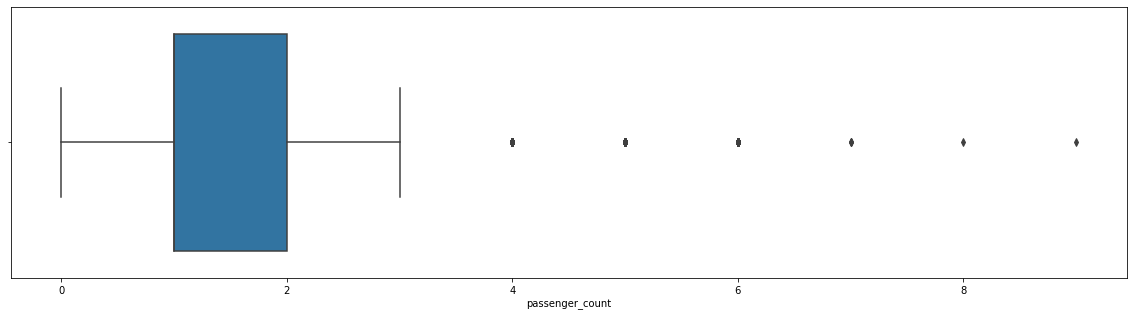

In [22]:
plt.figure(figsize = (20,5))
sns.boxplot(data.passenger_count)
plt.show()

### Observations:
- There are some trips with 0 passenger count. 
- Few trips consisted of even 7, 8 or 9 passengers. Clear outliers and pointers to data inconsistency
- Most of trip consist of passenger either 1 or 2.

### Idea:
Passenger count is a driver entered value. Since the trip is not possible without passengers. It is evident that the driver forgot to enter the value for the trips with 0 passenger count. Lets analyze the passenger count distribution further to make it consistent for further analysis

In [23]:
data.passenger_count.describe()

count   1458644.00
mean          1.66
std           1.31
min           0.00
25%           1.00
50%           1.00
75%           2.00
max           9.00
Name: passenger_count, dtype: float64

As per above details. Mean median and mode are all approx equal to 1. So we would replace the 0 passenger count with 1.

In [24]:
data['passenger_count'] = data.passenger_count.map(lambda x: 1 if x == 0 else x)

Also, we will remove the records with passenger count > 7, 8 or 9 as they are extreme values and looks very odd to be ocupied in a taxi. 

In [25]:
data = data[data.passenger_count <= 6]

In [26]:
data.passenger_count.value_counts()

1    1033600
2     210318
5      78088
3      59896
6      48333
4      28404
Name: passenger_count, dtype: int64

Now the data is consistent with respect to the passenger count. Let's take a look at the ditribution with a graph below

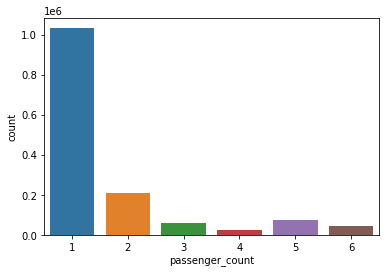

In [27]:
sns.countplot(data.passenger_count)
plt.show()

It is evident that most of the trips was taken by single passenger and that is inline with our day to day observations

<a id=vendor></a>
## Vendor
***
Here we analyze taxi data only for the 2 vendors which are listed as 1 and 2 in the datset.

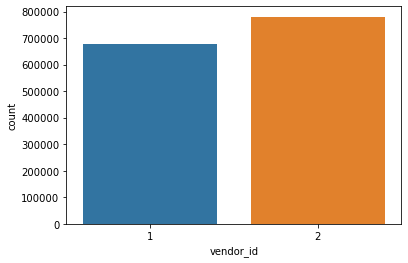

In [28]:
sns.countplot(data.vendor_id)
plt.show()

Though both the vendors seems to have almost equal market share. But Vendor 2 is evidently more famous among the population as per the above graph.


<a id='distance'></a>
## Distance
***
Let's now have a look on the distribution of the distance across the different types of rides.


<img src='https://developmentandleadership.org/wp-content/uploads/2016/06/iStock7114610XLARGEs-1024x680.jpg' align='left'/>

In [29]:
print(data.distance.describe())

count   1458639.00
mean          3.44
std           4.30
min           0.00
25%           1.23
50%           2.09
75%           3.88
max        1240.91
Name: distance, dtype: float64


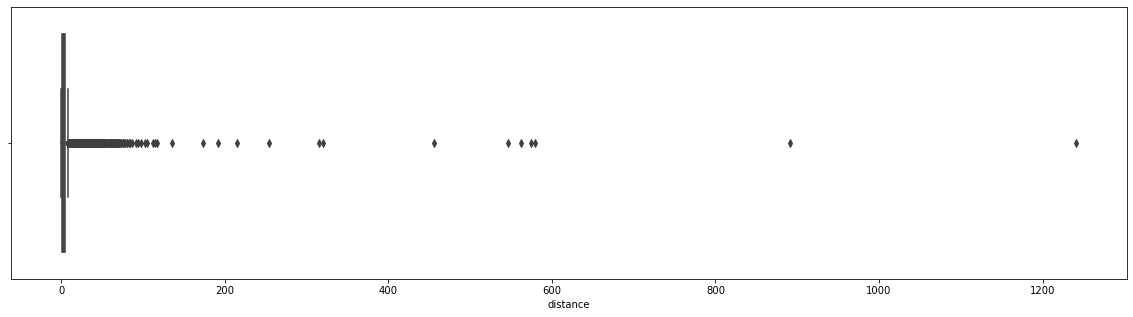

In [30]:
plt.figure(figsize = (20,5))
sns.boxplot(data.distance)
plt.show()

### Interesting find:
- There some trips with over 100 km distance.
- Some of the trips distance value is 0 km.

### Observations:
- mean distance travelled is approx 3.5 kms.
- standard deviation of 4.3 which shows that most of the trips are limited to the range of 1-10 kms.

In [31]:
print("There are {} trip records with 0 km distance".format(data.distance[data.distance == 0 ].count()))

There are 5895 trip records with 0 km distance


In [32]:
data[data.distance == 0 ].head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
246,id3487442,2,2016-02-29 18:39:12,2016-02-29 18:42:59,1,-73.98,40.77,-73.98,40.77,N,...,0,1,0,0,0,0,0,0,0,0
291,id0924324,2,2016-05-10 18:07:52,2016-05-10 18:26:21,2,-73.96,40.78,-73.96,40.78,N,...,0,0,1,0,0,0,0,0,0,0
407,id1145809,2,2016-05-16 23:15:13,2016-05-16 23:31:00,6,-73.81,40.69,-73.81,40.69,N,...,1,0,0,0,0,0,1,0,0,0
702,id3499387,1,2016-01-25 19:45:12,2016-01-25 19:54:52,1,-73.79,40.65,-73.79,40.65,N,...,0,1,0,0,0,0,0,0,0,0
1620,id0753277,1,2016-01-27 22:29:31,2016-01-27 22:29:58,1,-74.21,40.82,-74.21,40.82,N,...,0,1,0,0,0,0,0,0,0,0


### Observations
- Around 6K trip record with distance equal to 0. Below are some possible explanation for such records.
 1. Customer changed mind and cancelled the journey just after accepting it.
 2. Software didn't recorded dropoff location properly due to which dropoff location is the same as the pickup location.
 3. Issue with GPS tracker while the journey is being finished.
 4. Driver cancelled the trip just after accepting it due to some reason. So the trip couldn't start
 5. Or some other issue with the software itself which a technical guy can explain

There is some serious inconsistencies in the data where drop off location is same as the pickup location. We can't think off imputing the distance values considering a correlation with the duration because the dropoff_location coordinates would not be inline with the distance otherwise. We will look more to it in bivariate analysis with the Trip duration.

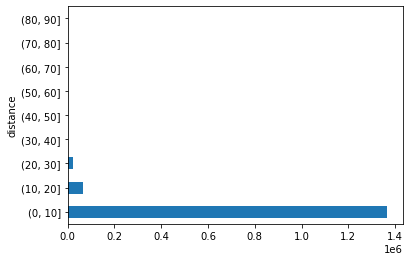

In [33]:
data.distance.groupby(pd.cut(data.distance, np.arange(0,100,10))).count().plot(kind='barh')
plt.show()

From the above observation it is evident that most of the rides are completed between 1-10 Kms with some of the rides with distances between 10-30 kms. Other slabs bar are not visible because the number of trips are very less as compared to these slabs

<a id='distance'></a>
## Distance
***
Let's now have a look on the distribution of the distance across the different types of rides.


<img src='https://developmentandleadership.org/wp-content/uploads/2016/06/iStock7114610XLARGEs-1024x680.jpg' align='left'/>

<a id='duration'></a>
## Trip Duration
***
<img src='https://i.imgur.com/2ZaOl33.png' align='left'/>

In [34]:
data.trip_duration.describe()

count   1458639.00
mean        959.50
std        5237.44
min           1.00
25%         397.00
50%         662.00
75%        1075.00
max     3526282.00
Name: trip_duration, dtype: float64

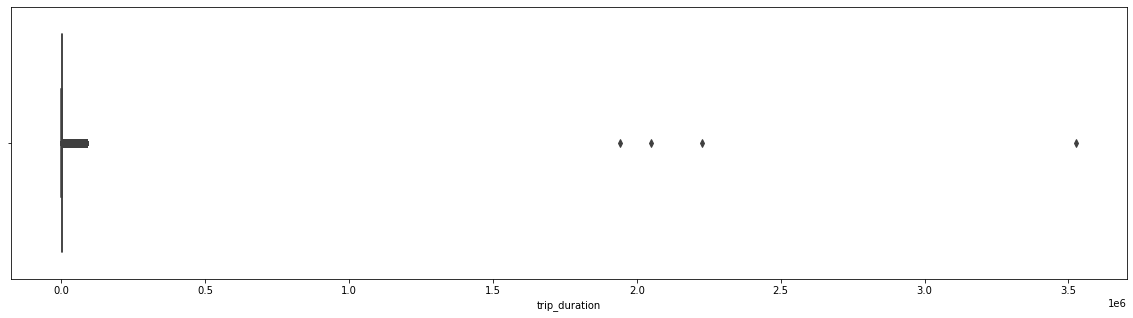

In [35]:
plt.figure(figsize = (20,5))
sns.boxplot(data.trip_duration)
plt.show()

### Interesting find:
- Some trip durations are over 100000 seconds which are clear outliers and should be removed.

### Observations:
 - There are some durations with as low as 1 second. which points towards trips with 0 km distance.
 - Major trip durations took between 10-20 mins to complete.
 - Mean and mode are not same which shows that trip duration distribution is skewed towards right.

Let's analyze more

In [36]:
data.trip_duration.groupby(pd.cut(data.trip_duration, np.arange(1,max(data.trip_duration),3600))).count()

trip_duration
(1, 3601]             1446308
(3601, 7201]            10045
(7201, 10801]             141
(10801, 14401]             35
(14401, 18001]              5
                       ...   
(3506401, 3510001]          0
(3510001, 3513601]          0
(3513601, 3517201]          0
(3517201, 3520801]          0
(3520801, 3524401]          0
Name: trip_duration, Length: 979, dtype: int64

### Observations:
 - There are some trips with more than 24 hours of travel duration i.e. 86400 seconds. Which might have occured on weekends for the outstation travels.
 - Major chunk of trips are completed within an interval of 1 hour with some good numbers of trips duration going above 1 hour.
 
Let's look at those trips with huge duration, these are outliers and should be removed for the data consistency.

In [37]:
data[data.trip_duration > 86400]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.79,40.64,-73.96,40.77,N,...,0,1,0,0,0,0,0,0,0,0
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.92,40.74,-73.98,40.76,N,...,0,0,1,0,0,0,0,0,0,0
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.98,40.74,-73.99,40.73,N,...,0,1,0,0,0,0,0,0,0,0
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.78,40.65,-73.98,40.75,N,...,0,1,0,0,0,0,0,0,0,0


### Observations:
 - These trips ran for more than 20 days, which seems unlikely by the distance travelled.
 - All the trips are taken by vendor 1 which points us to the fact that this vendor might allows much longer trip for outstations.
 - All these trips are either taken on Tuesday's in 1st month or Saturday's in 2nd month. There might be some relation with the weekday, pickup location, month and the passenger.
 - But they fail our purpose of correct prediction and bring inconsistencies in the algorithm calculation.
 
We should get rid of them for the sake of data consistency. Those are **black** swans !!

In [38]:
data = data[data.trip_duration <= 86400]

Let's visualize the number of trips taken in slabs of 0-10, 20-30 ... minutes respectively

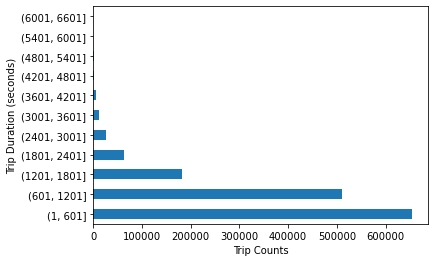

In [39]:
data.trip_duration.groupby(pd.cut(data.trip_duration, np.arange(1,7200,600))).count().plot(kind='barh')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()

We can observe that most of the trips took 0 - 30 mins to complete i.e. approx 1800 secs. Let's move ahead to next feature.

<a id=speed></a>
## Speed
***
Speed is a function of distance and time. Let's visualize speed in different trips.

Maximum speed limit in NYC is as follows:
- 25 mph in urban area i.e. **40 km/h**
- 65 mph on controlled state highways i.e. approx **104 km/h**

<img src='https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/281/gettyimages-56293248-speed-limit-image-source-1518561160.jpg' align='left'/>

In [40]:
data.speed.describe()

count   1458635.00
mean         14.42
std          14.98
min           0.00
25%           9.12
50%          12.79
75%          17.84
max        9274.85
Name: speed, dtype: float64

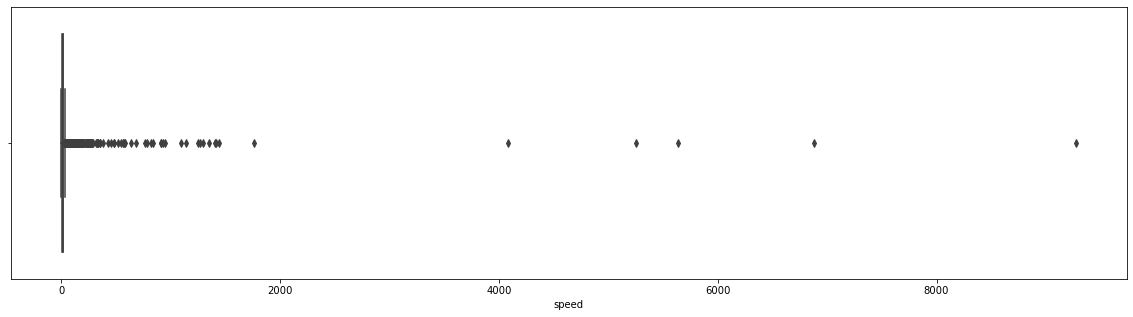

In [41]:
plt.figure(figsize = (20,5))
sns.boxplot(data.speed)
plt.show()

### Interesting find:
- Many trips were done at a speed of over 200 km/h. Going SuperSonic..!!

Let's remove them and focus on the trips which were done at less than 104 km/h as per the speed limits

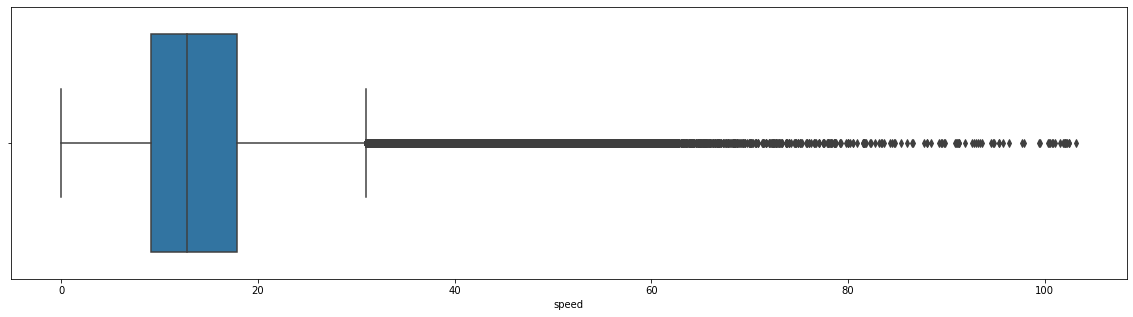

In [42]:
data = data[data.speed <= 104]
plt.figure(figsize = (20,5))
sns.boxplot(data.speed)
plt.show()

### Observations:
- Trips over 30 km/h are being considered as outliers but we cannot ignore them because they are well under the highest speed limit of 104 km/h on state controlled highways.
- Mostly trips are done at a speed range of 10-20 km/h with an average speed of around 14 km/h.

Let's take a look at the speed range ditribution with the help of graph.

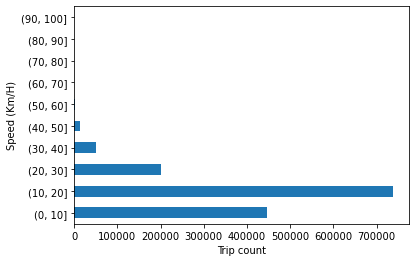

In [43]:
data.speed.groupby(pd.cut(data.speed, np.arange(0,104,10))).count().plot(kind = 'barh')
plt.xlabel('Trip count')
plt.ylabel('Speed (Km/H)')
plt.show()

It is evident from this graph what we thought off earlier i.e. most of the trips were done at a speed range of 10-20 km/H.

<a id=flag></a>
## Store_and_fwd_flag
***
This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip.

In [44]:
data.flag_Y.value_counts(normalize=True)

0   0.99
1   0.01
Name: flag_Y, dtype: float64

### Observations: 
- Above result shows that only about 1% of the trip details were stored in the vehicle first before sending it to the server. This might have occured because of the following reasons:
 1. Outstation trips didn't had proper connection at the time when trip completes.
 2. Temporary loss of signals while the trip was about to finish
 3. Inconsistent signal reception over the trip duration.
 4. The GPS or mobile device battery was down when the trip finished.

Let's check further


In [45]:
data.flag_Y.value_counts()

0    1450433
1       8044
Name: flag_Y, dtype: int64

Above result shows that around 8K trips had to store the flag and then report to the server when the connection was established. Let's check the respective distribution with the vendors for the offline trips.

In [46]:
data.vendor_id[data.flag_Y == 1].value_counts()

1    8044
Name: vendor_id, dtype: int64

### Observations:
- Above result shows that all the offline trips were taken by vendor 1. We already know that vendor 2 has greater market share as compared to vendor 1. So, there can be two reasons for this scenario.

 1. Either vendor 1 utilizes advance technology then vendor 2 to store and forward trip details in case of temporary signal loss.
 2. Or vendor 1 uses poor infrastructure which often suffers from the server connection instability due to which they have to store the trip info in the vehicle and send it to the server later when the server connection is back.

Let's check if there is some relation to the other metrics for these trips?

In [47]:
data[data.flag_Y == 1]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
348,id1633648,1,2016-06-20 14:19:16,2016-06-20 14:34:34,1,-73.98,40.75,-73.95,40.77,Y,...,0,1,0,0,0,0,0,0,0,0
491,id2042535,1,2016-02-12 12:36:38,2016-02-12 12:47:07,1,-73.98,40.76,-73.99,40.75,Y,...,0,1,0,0,0,0,0,0,0,0
610,id0909228,1,2016-05-08 15:02:28,2016-05-08 15:17:54,1,-73.99,40.74,-74.01,40.72,Y,...,0,1,0,0,0,0,0,0,0,0
774,id3697489,1,2016-01-13 13:53:29,2016-01-13 14:08:21,1,-73.95,40.78,-73.98,40.78,Y,...,0,1,0,0,0,0,0,0,0,0
846,id1026973,1,2016-06-25 21:53:30,2016-06-25 22:05:27,1,-73.98,40.76,-74.00,40.75,Y,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457556,id2229555,1,2016-01-22 19:05:50,2016-01-22 19:27:09,1,-73.87,40.77,-73.93,40.73,Y,...,0,1,0,0,0,0,0,0,0,0
1457670,id0510811,1,2016-04-07 21:14:30,2016-04-07 21:51:38,1,-73.78,40.64,-73.98,40.67,Y,...,0,1,0,0,0,0,0,0,0,0
1457897,id3209015,1,2016-03-20 18:49:55,2016-03-20 19:09:25,1,-73.99,40.71,-74.00,40.75,Y,...,0,1,0,0,0,0,0,0,0,0
1458060,id1371896,1,2016-03-28 11:45:49,2016-03-28 12:21:45,1,-73.97,40.76,-74.01,40.72,Y,...,0,1,0,0,0,0,0,0,0,0


### Observations:
 - Some trips are local some cover longer distance 
 - Almost each day is listed against offline trips.
 - Offline trips were taken almost at all hours as per the search result.
 - There is no month which appears to be more dominant in the results.
 - Even the trip duration covers different scales.

So all in all there doesn't seems to be any relation with either of the metric for the offline trips. Let's move ahead

<a id=hour_trip></a>
## Total trips Per Hour
***
Let's take a look at the distribution of the pickups across the 24 hour time scale.

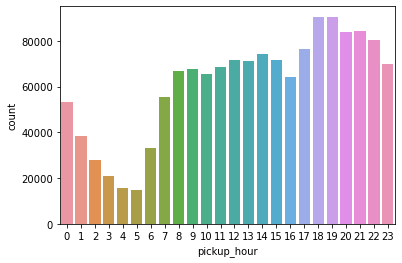

In [48]:
sns.countplot(data.pickup_hour)
plt.show()

### Observation
- It's inline with the general trend of taxi pickups which starts increasing from 6AM in the morning and then declines from late evening i.e. around 8 PM. There is no unusual behavior here.

<a id=week_trip></a>
## Total trips per weekday
***
Let's take a look now at the distribution of taxi pickups across the week.

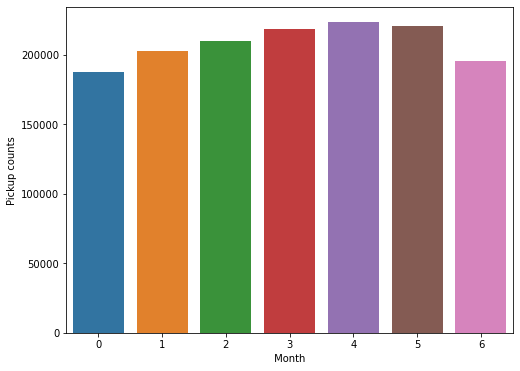

In [49]:
plt.figure(figsize = (8,6))
sns.countplot(data.weekday_num)
plt.xlabel(' Month ')
plt.ylabel('Pickup counts')
plt.show()

### Observation
- Here we can see an increasing trend of taxi pickups starting from Monday till Friday. The trend starts declining from saturday till monday which is normal where some office going people likes to stay at home for rest on the weekends. 

Let's drill down more to see the hourwise pickup pattern across the week

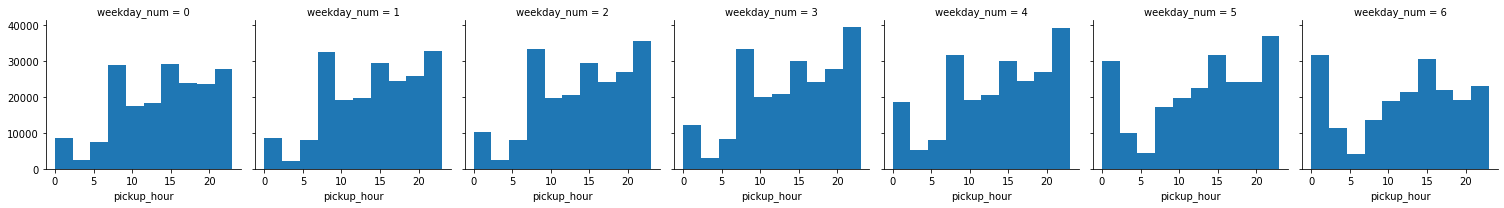

In [50]:
n = sns.FacetGrid(data, col='weekday_num')
n.map(plt.hist, 'pickup_hour')
plt.show()

### Interesting find:
 - Taxi pickups increased in the late night hours over the weekend possibly due to more outstation rides or for the late night leisures nearby activities.
 - Early morning pickups i.e before 5 AM have increased over the weekend in comparison to the office hours pickups i.e. after 7 AM which have decreased due to obvious reasons.
 - Taxi pickups seems to be consistent across the week at 15 Hours i.e. at 3 PM.

<a id=month_trip></a>
## Total trips per month
***
Let's take a look at the trip distribution across the months to understand if there is any diffrence in the taxi pickups in different months

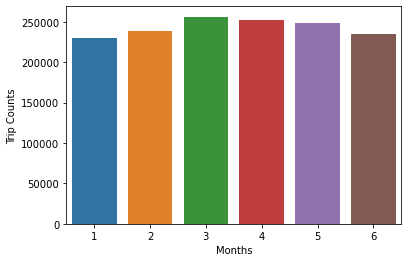

In [51]:
sns.countplot(data.month)
plt.ylabel('Trip Counts')
plt.xlabel('Months')
plt.show()

Quite a balance across the months here. It could have been more equivalent if we wouldn't have removed the inconsistent records in our study of the univariate analysis

<a id=bivariate></a>
# Bivariate Analysis
***
Bivariate analysis is used to find out if there is a relationship between two sets of values. It usually involves the variables X and Y.


<img src='https://i.pinimg.com/originals/c8/d4/0e/c8d40e9ec4ffd4f3af527eb40ba80462.gif' align='left'/>

<a id=hour_duration></a>
## Trip Duration per hour
***
We need to aggregate the total trip duration to plot it agaist the month. The aggregation measure can be anything like sum, mean, median or mode for the duration. Since we already did the outlier analysis, so we can take the mean to visualize the pattern which should not result in the bias of the general trend.
 - Lets take a look.

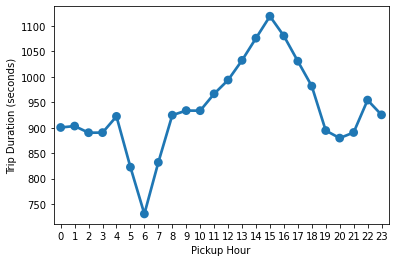

In [52]:
group1 = data.groupby('pickup_hour').trip_duration.mean()
sns.pointplot(group1.index, group1.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Pickup Hour')
plt.show()

### Observations:
- Average trip duration is lowest at 6 AM when there is minimal traffic on the roads.
- Average trip duration is generally highest around 3 PM during the busy streets.
- Trip duration on an average is similar during early morning hours i.e. before 6 AM & late evening hours i.e. after 6 PM.

<a id=week_duration></a>
## Trip duration per weekday
***
Let's now analyze the pattern of trip duration during the week.

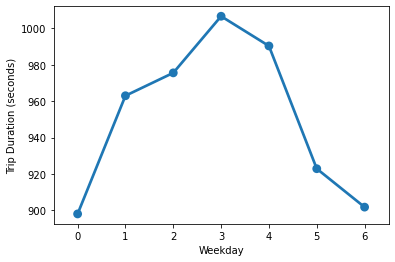

In [53]:
group2 = data.groupby('weekday_num').trip_duration.mean()
sns.pointplot(group2.index, group2.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Weekday')
plt.show()

We can see that trip duration is almost equally distributed across the week on a scale of 0-1000 minutes with minimal difference in the duration times. Also, it is observed that trip duration on thursday is longest among all days.

<a id=month_duration></a>
## Trip duration per month
***
Let's take a look at the trip duration pattern with respect to the different months.

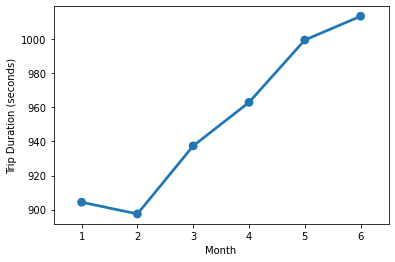

In [54]:
group3 = data.groupby('month').trip_duration.mean()
sns.pointplot(group3.index, group3.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Month')
plt.show()

### Observations:
- We can see an increasing trend in the average trip duration along with each subsequent month. 
- The duration difference between each month is not much. It has increased gradually over a period of 6 months.
- It is lowest during february when winters starts declining.
- There might be some seasonal parameters like wind/rain which can be a factor of this gradual increase in trip duration over a period. Like May is generally the considered as the wettest month in NYC and which is inline with our visualization. As it generally takes longer on the roads due to traffic jams during rainy season. So natually the trip duration would increase towards April May and June.

<a id=vendor_duration></a>
## Trip duration per vendor
***
We can also look at the average difference between the trip duration for each vendor. However we do know that vendor 2 has larger share of the market. Let's visualize.

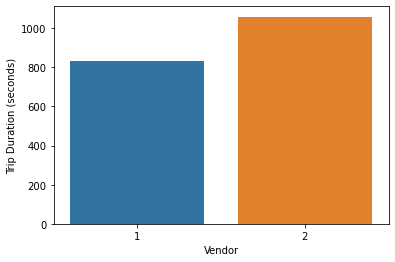

In [55]:
group4 = data.groupby('vendor_id').trip_duration.mean()
sns.barplot(group4.index, group4.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Vendor')
plt.show()

Vendor 2 takes the crown. Average trip duration for vendor 2 is higher than vendor 1 by approx 200 seconds i.e. atleast 3 minutes per trip.

<a id=flag_duration></a>
## Trip duration v/s Flag
***
Let's visualize if there is any effect of flag setting on the trip duration?

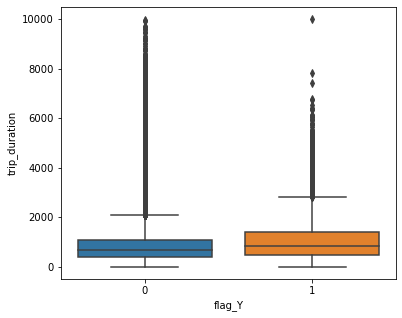

In [56]:
plt.figure(figsize = (6,5))
plot_dur = data.loc[(data.trip_duration < 10000)]
sns.boxplot(x = "flag_Y", y = "trip_duration", data = plot_dur)
plt.show()

### Observations:
- Trip durations scale is less for the trips where the flag is set i.e. the trip details are stored before sending it to the server.
- Trip duration outliers are also less for the trips with flag 'Y' as compared the trips with flag 'N'.
- Trip duration is longer for the trips where the flag is not set.
- Inter quartile range of trip duration is more for the trips with the flag 'Y' as compared to the trips with flag 'N' but the median value is almost equal for both.

<a id=hour_distance></a>
## Distance per hour
***
Now, let us check how the distance is distributed against different variables. We know that trip distance must be more or less proportional to the trip duration if we ignore general traffic and other stuff on the road. Let's visualize this for each hour now. 

Since we have already done the outlier analysis for this variable as well. We can take the mean as aggregate measure for our visualizations.

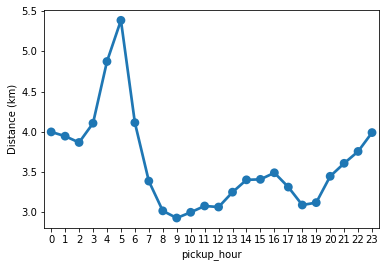

In [57]:
group5 = data.groupby('pickup_hour').distance.mean()
sns.pointplot(group5.index, group5.values)
plt.ylabel('Distance (km)')
plt.show()

### Observations:
- Trip distance is highest during early morning hours which can account for some things like:
 1. Outstation trips taken during the weekends.
 2. Longer trips towards the city airport which is located in the outskirts of the city.
- Trip distance is fairly equal from morning till the evening varying around 3 - 3.5 kms.
- It starts increasing gradually towards the late night hours starting from evening till 5 AM and decrease steeply towards morning.

<a id=week_distance></a>
## Distance per weekday
***
Let's analyze the average trip distance covered on each day of the week.

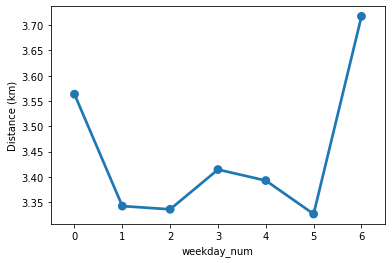

In [58]:
group6 = data.groupby('weekday_num').distance.mean()
sns.pointplot(group6.index, group6.values)
plt.ylabel('Distance (km)')
plt.show()

So it's a fairly equal distribution with average distance metric verying around 3.5 km/h with Sunday being at the top may be due to outstation trips or night trips towards the airport.

<a id=month_distance></a>
## Distance per month
***
Now we will look at the average trip distance covered per month.

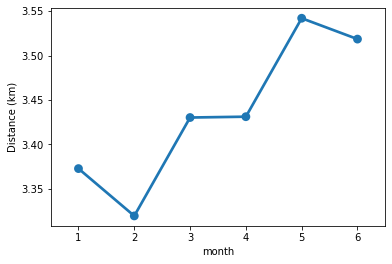

In [59]:
group7 = data.groupby('month').distance.mean()
sns.pointplot(group7.index, group7.values)
plt.ylabel('Distance (km)')
plt.show()

Here also the distibution is almost equivalent, varying mostly around 3.5 km/h with 5th month being the highest in the average distance and 2nd month being the lowest.

<a id=vendor_distance></a>
## Distance per vendor
***
Let's check how both the vendors have covered the average distance during the trips

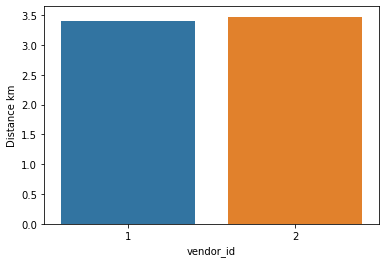

In [60]:
group8 = data.groupby('vendor_id').distance.mean()
sns.barplot(group8.index, group8.values)
plt.ylabel("Distance km")
plt.show()

This is more or less same picture with both the vendors. Nothing more to analyze in this.

<a id=flag_distance></a>
## Distance v/s Flag
***
Let's visualize if there is any effect of Flag setting on the distance covered in the trips

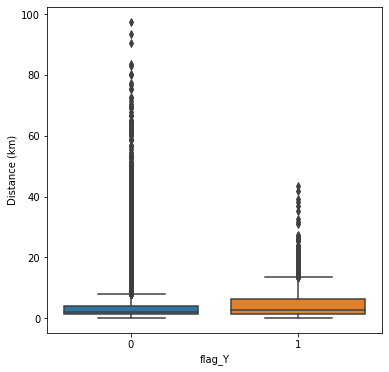

In [61]:
plt.figure(figsize = (6,6))
plot_dist = data.loc[(data.distance < 100)]
sns.boxplot(x = "flag_Y", y = "distance", data = plot_dist)
plt.ylabel('Distance (km)')
plt.show()

### Observations:
- We can see almost similar results like the one observed in the Trip duration v/s Flag analysis.
- Only two major difference can be seen here.
 1. Interquartile range of distance is almost twice for Flag 'Y' trips as compared to the Flag 'N' trips
 2. Median value is much different in both the case as well.

Which points us to the fact that range of distance and trip duration for the Flag 'Y' trips is much more limited and confined as compared with the flag 'N' trips and this also resulted in much less number of outliers for Flag 'Y' trips.

<a id=duration_distance></a>
## Distance v/s Trip duration
***
Let's visualize the relationship between Distance covered and respective trip duration.

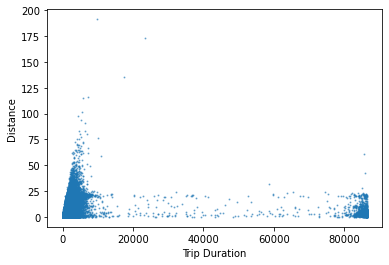

In [62]:
plt.scatter(data.trip_duration, data.distance , s=1, alpha=0.5)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.show()

### Interesting find:
- There are lots of trips which covered negligible distance but clocked more than 20,000 seconds in terms of the Duration.
- Initially there is some proper correlation between the distance covered and the trip duration in the graph. but later on it all seems uncorrelated.
- There were few trips which covered huge distance of approx 200 kms within very less time frame, which is unlikely and should be treated as outliers.

Let's focus on the graph area where distance is < 50 km and duration is < 1000 seconds.

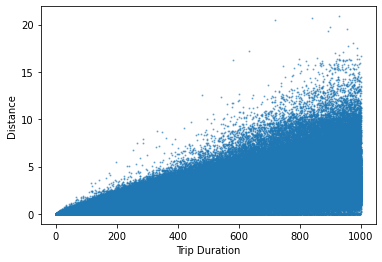

In [63]:
dur_dist = data.loc[(data.distance < 50) & (data.trip_duration < 1000), ['distance','trip_duration']]
plt.scatter(dur_dist.trip_duration, dur_dist.distance , s=1, alpha=0.5)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.show()

### Observations:
- There should have been a linear relationship between the distance covered and trip duration on an average but we can see dense collection of the trips in the lower right corner which showcase many trips with the inconsistent readings.

### Idea:
We should remove those trips which covered 0 km distance but clocked more than 1 minute to make our data more consistent for predictive model. Because if the trip was cancelled after booking, than that should not have taken more than a minute time. This is our assumption.

In [64]:
data = data[~((data.distance == 0) & (data.trip_duration >= 60))]

Now, Instead of looking at each and every trip, we should approximate and try to filter those trips which covered less than 1 km distance and but clocked more than an hour.

In [65]:
duo = data.loc[(data['distance'] <= 1) & (data['trip_duration'] >= 3600),['distance','trip_duration']].reset_index(drop=True)

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

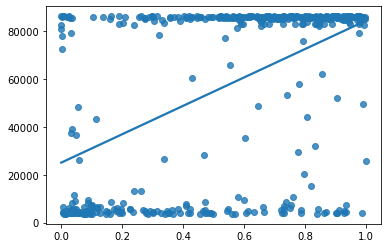

In [66]:
sns.regplot(duo.distance, duo.trip_duration)
plt.show()

### Observations:
 - Though the straight line tries to show some linear relation between the two. But there seems to be negligible correlation between these two metric as seen from the scatter plot where it should have been a linear distribution.
 - It is rarely occurs that customer keep sitting in the taxi for more than an hour and it does not travel for even 1 km.
 
These should be removed to bring in more consistency to our results.

In [67]:
data = data[~((data['distance'] <= 1) & (data['trip_duration'] >= 3600))]

<a id=speed_hour></a>
## Average speed per hour
***
Let's look at the average speed of NYC Taxi per hour.

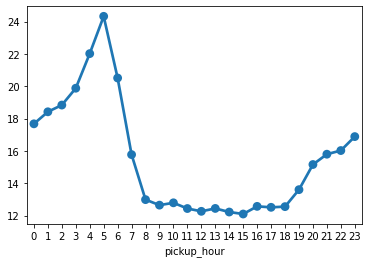

In [68]:
group9 = data.groupby('pickup_hour').speed.mean()
sns.pointplot(group9.index, group9.values)
plt.show()

### Observation
- The average trend is totally inline with the normal circumstances.
- Average speed tend to increase after late evening and continues to increase gradually till the late early morning hours.
- Average taxi speed is highest at 5 AM in the morning, then it declines steeply as the office hours approaches.
- Average taxi speed is more or less same during the office hours i.e. from 8 AM till 6PM in the evening.

<a id=speed_weekday></a>
## Average speed per weekday
***
Let's visualize that on an average what is the speed of a taxi on any given weekday.

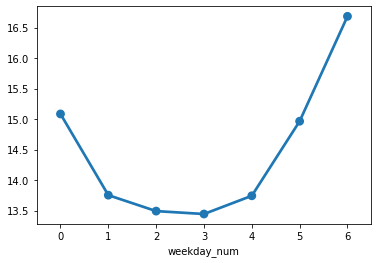

In [69]:
group10 = data.groupby('weekday_num').speed.mean()
sns.pointplot(group10.index, group10.values)
plt.show()

### Observations
- Average taxi speed is higher on weekend as compared to the weekdays which is obvious when there is mostly rush of office goers and business owners.
- Even on monday the average taxi speed is shown higher which is quite surprising when it is one of the most busiest day after the weekend. There can be several possibility for such behaviour
 1. Lot of customers who come back from outstation in early hours of Monday before 6 AM to attend office on time.
 2. Early morning hours customers who come from the airports after vacation to attend office/business on time for the coming week.
- There could be some more reasons as well which only a local must be aware of. 
- We also can't deny the anomalies in the dataset. which is quite cumbersome to spot in such a large dataset.

<a id=passenger_vendor></a>
## Passenger count per vendor
***
Let's try some different metric in the series i.e. passenger count. We will plot it agaist the vendor only because it will not be much helpful to plot it against hour, weekday or month like others as the passenger count should be a whole number and not a ratio. 

we will take mean as the aggregate measure because we already did the outlier analysis on this metric. So our results woudn't be affected by some extreme values. Also if we take median than it will return only 1 because majorty of the trips have been taken by single passenger. Let's take a look about it's distribution.

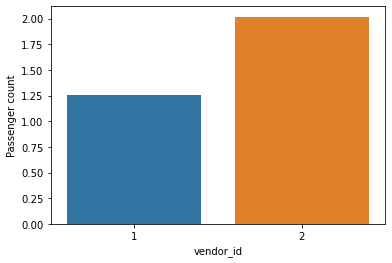

In [70]:
group9 = data.groupby('vendor_id').passenger_count.mean()
sns.barplot(group9.index, group9.values)
plt.ylabel('Passenger count')
plt.show()

Clear difference between the two operators for the average passenger count in all trips. It seems that vendor 2 trips generally consist of 2 passengers as compared to the vendor 1 with 1 passenger. Let's bifurcate it further.

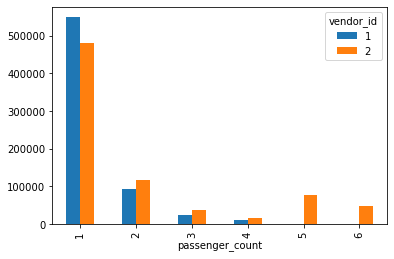

In [71]:
data.groupby('passenger_count').vendor_id.value_counts().reset_index(name='count').pivot("passenger_count","vendor_id","count").plot(kind='bar')
plt.show()

### Interesting find
- It seems that most of the big cars are served by the Vendor 2 including minivans because other than passenger 1, vendor 2 has majority in serving more than 1 passenger count and that explains it greater share of the market.

<a id=map></a>
# Map Visualization
***
We shall visualize the Taxi pickup locations by placing long and lat marker on the MAP of the US. So that we can analyze below questions:
 - Are all pickups constrained to NYC and it's surrounding areas?
 - Is there any unusual location of the pickup?
 - Are the lat long constrained to the land area of the US and nowhere else?
 
 <img src='https://cdn.dribbble.com/users/22930/screenshots/1919115/line-art-map_2.gif' align='left'/>


<a id=basemap></a>
## Basemap
***
We will utilize the matplotlib basemap toolkit library for plotting the maps. It is very lightweight and easy to use. Let's define a **map_marker** function for our purpose of visualizing long lat marker on the map.

In [72]:
def map_marker(set):
    # Import package for map
    from mpl_toolkits.basemap import Basemap
    plt.figure(figsize = (20,20))

    # Set the limits of the map to the minimum and maximum coordinates
    lat_min = data["pickup_latitude"].min() - .2
    lat_max = data["pickup_latitude"].max() + .2
    lon_min = data["pickup_longitude"].min() - .2
    lon_max = data["pickup_longitude"].max() + .2

    # Set the center of the map
    cent_lat = (lat_min + lat_max) / 2
    cent_lon = (lon_min + lon_max) / 2

    #Create the Basemap object with required params.
    map = Basemap(llcrnrlon=lon_min,
                  llcrnrlat=lat_min,
                  urcrnrlon=lon_max,
                  urcrnrlat=lat_max,
                  resolution='l',
                  projection='tmerc',
                  lat_0 = cent_lat,
                  lon_0 = cent_lon)

    #Style the map
    map.drawmapboundary()
    map.drawcoastlines()
    map.fillcontinents()
    map.drawcountries(linewidth=2)
    map.drawstates()


    #Fetch the long and lat in form of array
    long = np.array(data["pickup_longitude"])
    lat = np.array(data["pickup_latitude"])

    x, y = map(long, lat)
    map.plot(x, y,'ro', markersize=2, alpha=1)

    plt.show()

<a id=pickup></a>
## Taxi pickup locations
***
Let's call the map_marker function to visualize all the pickup locations in the dataset.

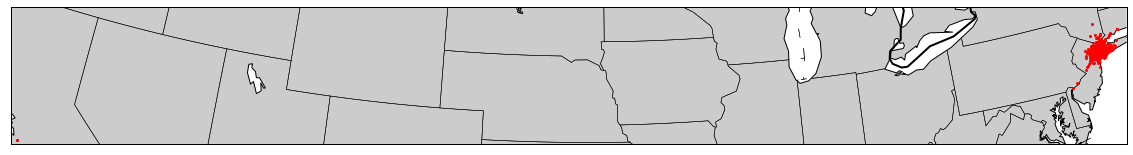

In [73]:
map_marker(data)

### Interesting Find
Here are some observations from the map:
 - One unusual pickup from the CA state.
 - There are quite a few pickup from the neighbouring state as well. Some are quite far and some very near to the NYC state.

We should check the validity of the unusual pickup here and take corrective actions if necessary. Let's take a closer look.

In [74]:
#CA state pickup
data[data.pickup_longitude == data.pickup_longitude.min()]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
1184454,id2854272,2,2016-02-26 13:50:19,2016-02-26 13:58:38,2,-121.93,37.39,-121.93,37.39,N,...,0,0,1,0,0,0,0,0,0,0


We can see that though the trip duration is approx 8 minutes still the distance travelled is just in few meters. Moreover the Lat and Lon readings are same. That is a **black** swan and should be removed for the consistency of the model. Let's remove it now.

In [75]:
data = data[data.pickup_longitude != data.pickup_longitude.min()]

Let's check whether those have been removed from the map or not?

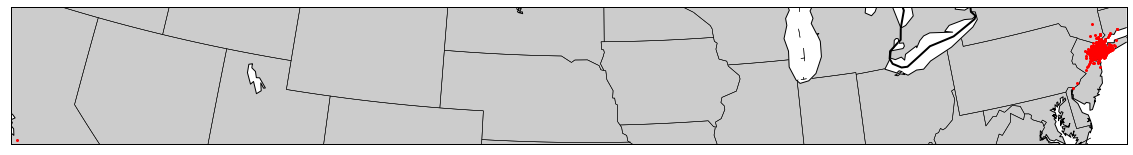

In [76]:
map_marker(data)

### Interesting find
We can still see a marker in the CA state. 

### Idea
Were there more than one pickups in the CA or the data is still not filtered?

Let's check this again

In [77]:
data[data.pickup_longitude == data.pickup_longitude.min()]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
1068810,id3777240,2,2016-01-27 18:26:40,2016-01-27 18:45:05,2,-121.93,37.39,-121.93,37.39,N,...,0,0,1,0,0,0,0,0,0,0


So this one is a different pickup but with the same story like the previous one i.e. the trip duration is not in correlation with the distance covered.

Let's remove this one as well and call up the map_marker to check the latest picture.

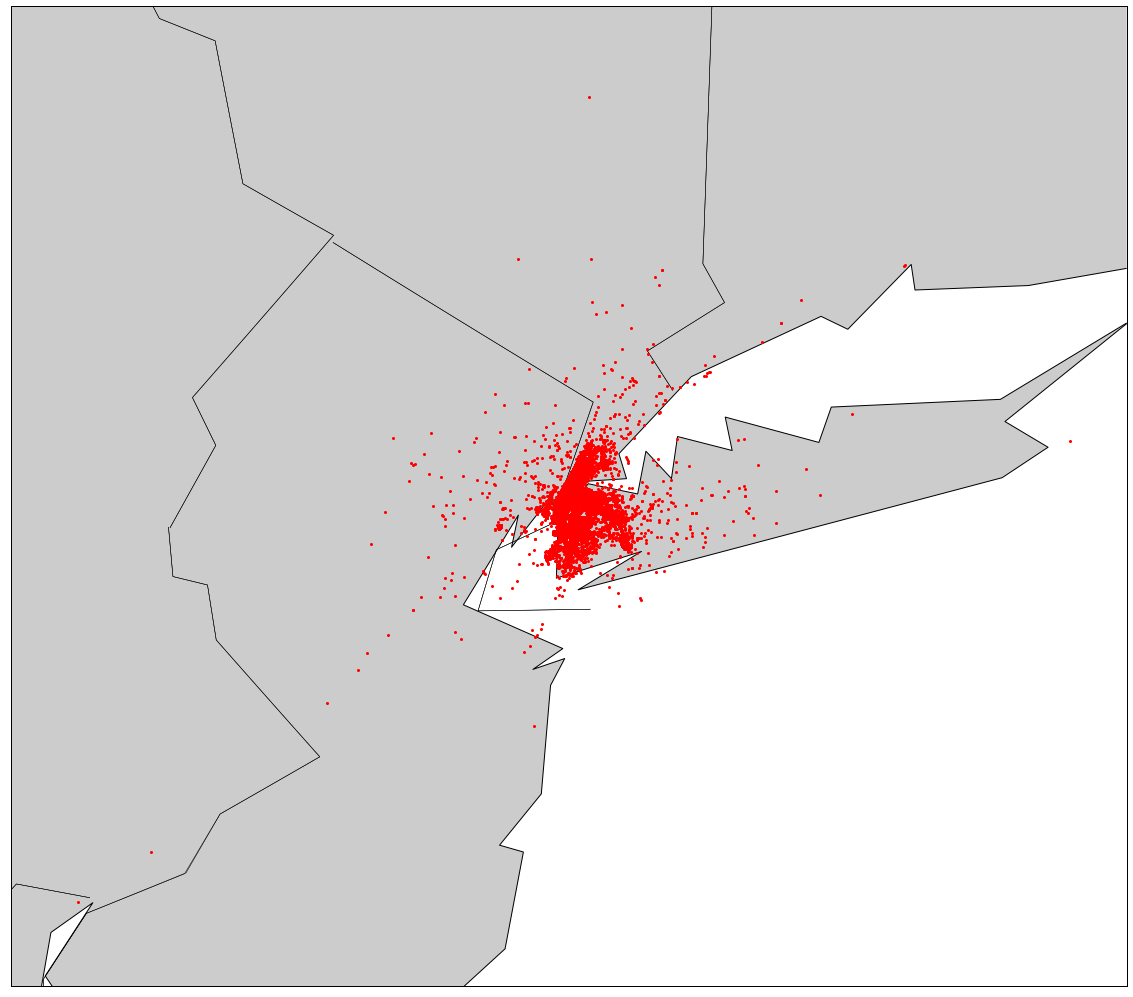

In [78]:
data = data[data.pickup_longitude != data.pickup_longitude.min()]
map_marker(data)

### Interesting find
- There are quite a few pickups being shown off the NYC coast i.e. in the Atlantic ocean. 

### Observations
- Now most of the pickups are being shown in and around NYC area.
- It would be cumbersome to track them and remove. We can ignore them as of now to focus more on NYC pickups.

<a id=nyc_pick></a>
## NYC pickup locations
***
Now, let's focus on the taxi pickups in the NYC area. And for that we have to fix the Longitude and latitude to view only the NYC area map. Let's do that now and visualize the pickup locations.

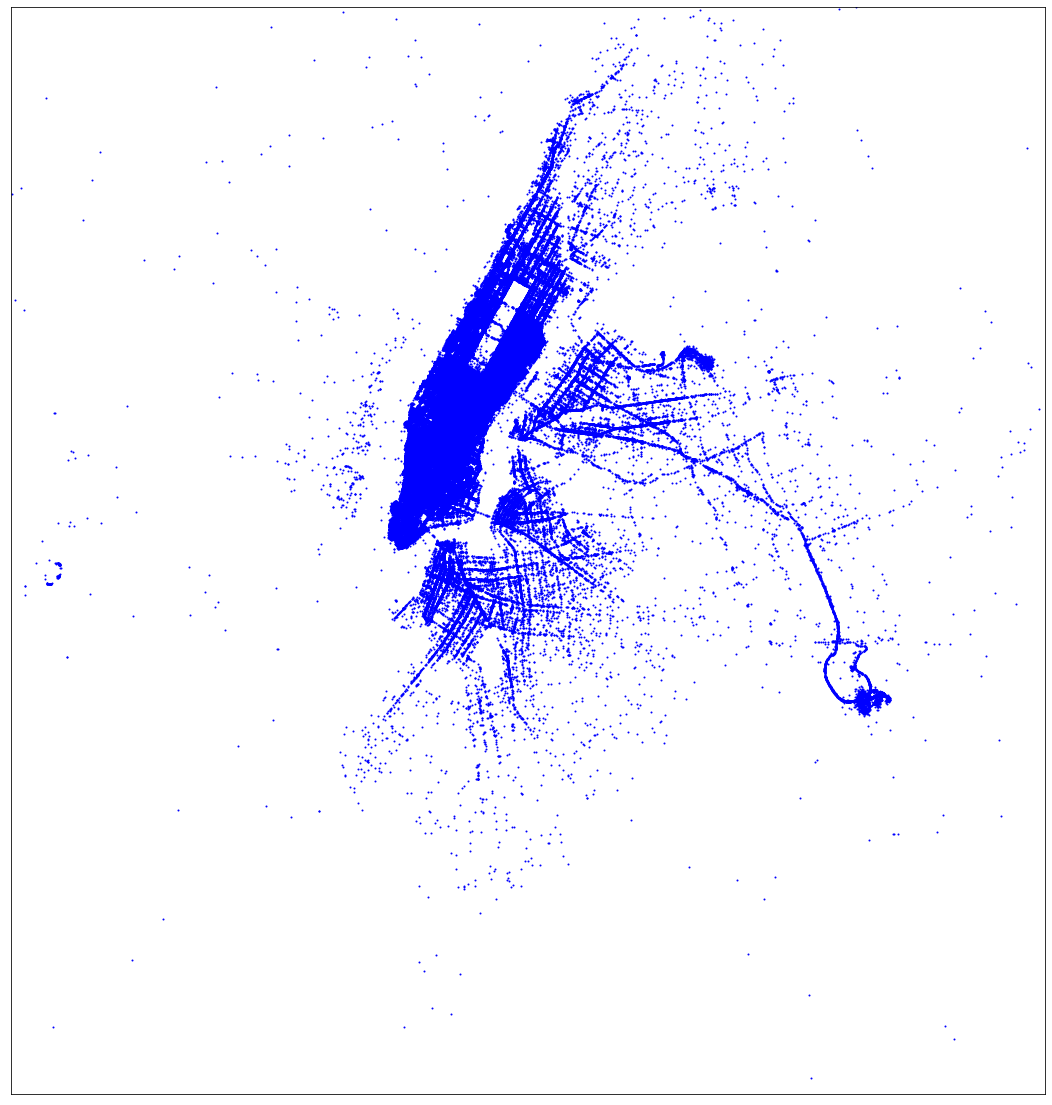

In [79]:
plt.figure(figsize=(20,20))
from mpl_toolkits.basemap import Basemap

# Set the limits of the map to the minimum and maximum coordinates
lat_min = 40.5
lat_max = 40.9
lon_min = -74.2
lon_max = -73.7

# Set the center of the map
cent_lat = (lat_min + lat_max) / 2
cent_lon = (lon_min + lon_max) / 2

#Create the Basemap object with required params.
map = Basemap(llcrnrlon=lon_min,
              llcrnrlat=lat_min,
              urcrnrlon=lon_max,
              urcrnrlat=lat_max,
              resolution='l',
              projection='tmerc',
              lat_0 = cent_lat,
              lon_0 = cent_lon)

#Style the map
# map.drawcounties()

#Fetch the long and lat in form of array
long = np.array(data["pickup_longitude"])
lat = np.array(data["pickup_latitude"])

x, y = map(long, lat)
map.plot(x, y,'bo', markersize=1, alpha=1)
plt.xticks()
plt.show()

### Interesting Find
 - We can see that most of the taxi pickups were done in the manhattan area as compared to the other areas in NYC.
 - A long trail towards the airport shows that the airport is situated quite far from the Manhattan area.
 
### Observations
 - There must have been some long distance rides towards and from the airport.
 - Similarly the average duration for the rides picked-up to or for the airport would have been longer.


<a id=nyc_drop></a>
## NYC dropoff locations
***
Now let's take a look at the taxi dropoff's

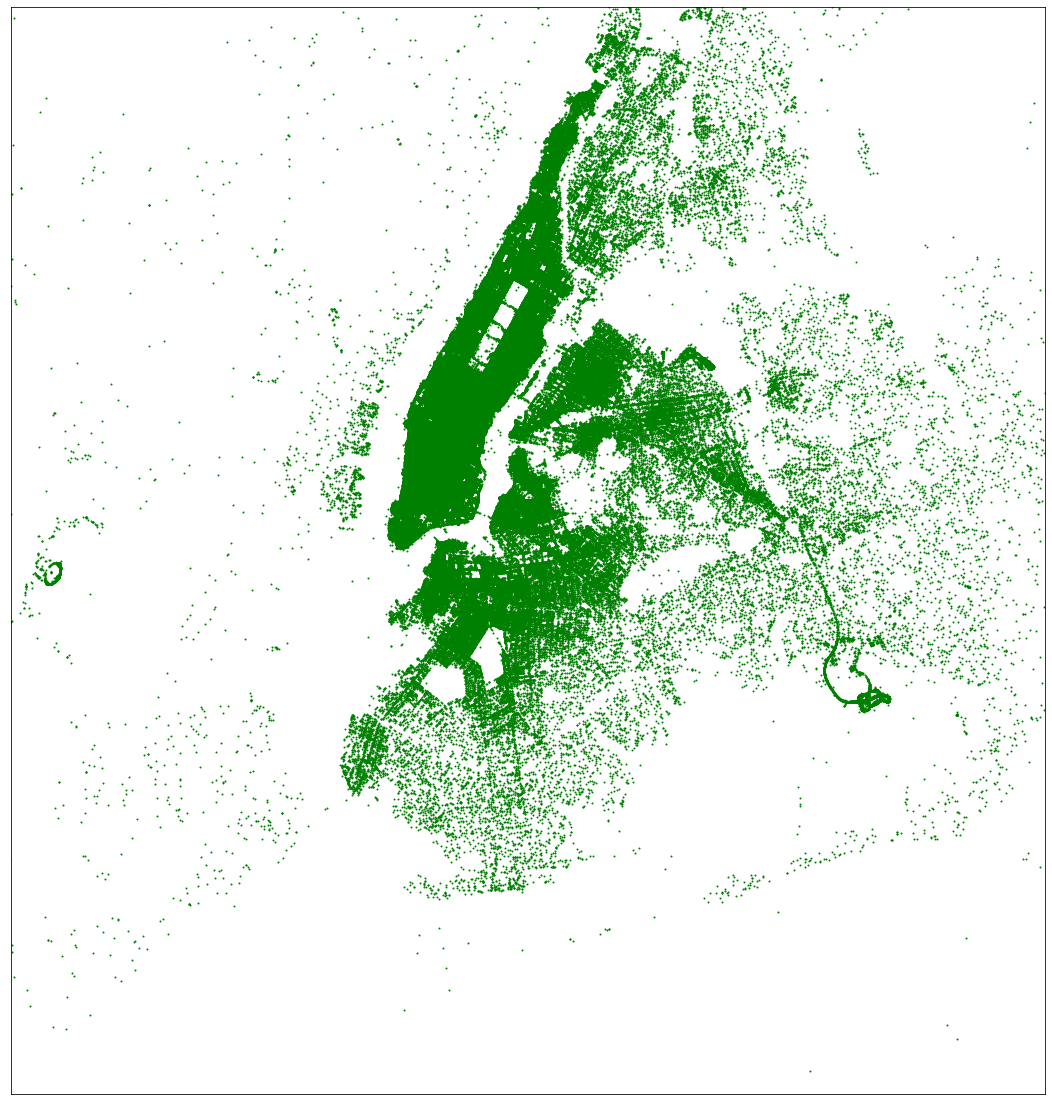

In [80]:
plt.figure(figsize=(20,20))

# Set the limits of the map to the minimum and maximum coordinates
lat_min = 40.5
lat_max = 40.9
lon_min = -74.2
lon_max = -73.7

# Set the center of the map
cent_lat = (lat_min + lat_max) / 2
cent_lon = (lon_min + lon_max) / 2

#Create the Basemap object with required params.
map = Basemap(llcrnrlon=lon_min,
              llcrnrlat=lat_min,
              urcrnrlon=lon_max,
              urcrnrlat=lat_max,
              resolution='l',
              projection='tmerc',
              lat_0 = cent_lat,
              lon_0 = cent_lon)

#Style the map
# map.drawcounties()

#Fetch the long and lat in form of array
long = np.array(data["dropoff_longitude"])
lat = np.array(data["dropoff_latitude"])

x, y = map(long, lat)
map.plot(x, y,'go', markersize=1, alpha=1)
plt.xticks()
plt.show()

### Interesting Find:

Dropoff's are much more distributed around the NYC area where still most of the dropoff's were done in the Manhattan. 

### Question:

Does that mean there were more dropoff's than the pickup's?

### Idea:

Though the dropoffs seems to be larger in number than the pickups. But we know that for each pickup we have a associated dropoffs in the dataset. It's just that the pickups were majorly concentrated in the Manhattan area.

<a id=feature></a>
## Feature Engineering
***
After looking at the dataset from different perspectives. Let's prepare our dataset before training our model. Since our dataset do not contain very large number of dimensions. We will first try to use feature selection instead of the feature extraction technique.

<img src='https://www.netsoftlab.com/images/full-flash.gif' align='left'/>

### Question: 
But what's the difference?
 - **Feature selection**: we select a subset of the original feature set based on the statistical significance of different parameters.
 > Example: Backward elimination, Forward selection, Recursive feature elimination
 - **Feature extraction**: we build a new set of features from the original feature set
 > Example: PCA, LDA, Kernel PCA

<a id=select></a>
## Feature Selection
***
#### Intuition
 - We will use **backward elimination** technique to select the best features to train our model. 
 - It displays some statistical metrics with there significance value.
 - Like, It shows the **p** values for each feature as per its significance in the whole dataset.
 - It also shows the **adjusted R squared** values to identify whether removing or selecting the feature is beneficial or not.
 - For now we will only look at the P and adjusted R squared value to decide which features to keep and which needed to be removed.
 
Let's assign the values to X & Y array from the dataset.

In [81]:
#First chech the index of the features and label
list(zip( range(0,len(data.columns)),data.columns))

[(0, 'id'),
 (1, 'vendor_id'),
 (2, 'pickup_datetime'),
 (3, 'dropoff_datetime'),
 (4, 'passenger_count'),
 (5, 'pickup_longitude'),
 (6, 'pickup_latitude'),
 (7, 'dropoff_longitude'),
 (8, 'dropoff_latitude'),
 (9, 'store_and_fwd_flag'),
 (10, 'trip_duration'),
 (11, 'weekday'),
 (12, 'month'),
 (13, 'weekday_num'),
 (14, 'pickup_hour'),
 (15, 'distance'),
 (16, 'speed'),
 (17, 'flag_Y'),
 (18, 'vendor_id_2'),
 (19, 'month_2'),
 (20, 'month_3'),
 (21, 'month_4'),
 (22, 'month_5'),
 (23, 'month_6'),
 (24, 'weekday_num_1'),
 (25, 'weekday_num_2'),
 (26, 'weekday_num_3'),
 (27, 'weekday_num_4'),
 (28, 'weekday_num_5'),
 (29, 'weekday_num_6'),
 (30, 'pickup_hour_1'),
 (31, 'pickup_hour_2'),
 (32, 'pickup_hour_3'),
 (33, 'pickup_hour_4'),
 (34, 'pickup_hour_5'),
 (35, 'pickup_hour_6'),
 (36, 'pickup_hour_7'),
 (37, 'pickup_hour_8'),
 (38, 'pickup_hour_9'),
 (39, 'pickup_hour_10'),
 (40, 'pickup_hour_11'),
 (41, 'pickup_hour_12'),
 (42, 'pickup_hour_13'),
 (43, 'pickup_hour_14'),
 (44, 'pic

In [82]:
Y = data.iloc[:,10].values
X = data.iloc[:,range(15,61)].values

### Question: 
Why few features are not assigned to the X array like features at the index 2,3,10 were missed?

### Idea:
 - **duration** variable assigned to Y because that is the dependent variable.
 - features such as  **id, timestamp** and **weekday** were not assigned to X array because they are of type object. And we need an array of float data type.
 
#### Trick for backward elimination:
General equation for multiple linear regression is like
> Y = a0 + a1x1 + a2x2 + ... + anxn

Since, we dont have x0 in our X array so the regressor won't consider the constant value of the equation i.e. **a0**.
So to make it count in the equation we will append the selected feature set with a contant series of 1's as a first column. To make it appear like below equation to the statsmodel.
> y = a0x0 + a1x1 + a2x2 + ... + anxn

In [83]:
print("Let's append {} rows of 1's as the first column in the X array".format(X.shape[0]))

Let's append 1453809 rows of 1's as the first column in the X array


In [84]:
X1 = np.append(arr = np.ones((X.shape[0],1)).astype(int), values = X, axis = 1)

In [85]:
X1.shape

(1453809, 47)

There we go, our feature set is now ready for the feature selection model with 1s in the first column for a0 constant.

Let's fit stats model on the X array to figure out an optimal set of features by recursively checking for the highest p value and removing the feature of that index.

### Note:
Here we will take the level of significance as 0.05 i.e. 5% which means that we will reject feature from the list of array and re-run the model till p value for all the features goes below .05 to find out the optimal combination for our model.

In [86]:
# X_opt = X1[:,[0,1,3,4,6,7,8,9,10,11]]
# regressor_OLS = sm.OLS(endog = Y, exog = X_opt).fit()
# regressor_OLS.summary()

In [89]:
#Select all the features in X array
X_opt = X1[:,range(0,46)]
regressor_OLS = sm.OLS(endog = Y, exog = X_opt).fit()

#Fetch p values for each feature
p_Vals = regressor_OLS.pvalues

#define significance level for accepting the feature.
sig_Level = 0.05

#Loop to iterate over features and remove the feature with p value less than the sig_level
while max(p_Vals) > sig_Level:
    print("Probability values of each feature \n")
    print(p_Vals)
    X_opt = np.delete(X_opt, np.argmax(p_Vals), axis = 1)
    print("\n")
    print("Feature at index {} is removed \n".format(str(np.argmax(p_Vals))))
    print(str(X_opt.shape[1]-1) + " dimensions remaining now... \n")
    regressor_OLS = sm.OLS(endog = Y, exog = X_opt).fit()
    p_Vals = regressor_OLS.pvalues
    print("=================================================================\n")
    
#Print final summary
print("Final stat summary with optimal {} features".format(str(X_opt.shape[1]-1)))
regressor_OLS.summary()

Probability values of each feature 

[1.25386945e-001 0.00000000e+000 0.00000000e+000 5.69458552e-001
 1.91877516e-305 2.61611496e-001 3.80116434e-001 7.81119860e-001
 1.08730059e-001 3.30664112e-002 4.64186221e-001 8.08917540e-002
 3.44783472e-001 8.44360512e-001 2.41881694e-005 1.87736835e-018
 2.09138154e-003 7.20755407e-008 1.46480543e-011 7.60708520e-016
 3.14597139e-016 2.10965920e-005 1.71382389e-004 5.78239094e-017
 1.57382483e-017 4.41592471e-020 5.75360137e-026 3.87765436e-020
 3.27047462e-019 4.28344184e-022 2.52487394e-016 2.54093176e-016
 6.36857200e-021 2.75172527e-021 4.15915271e-022 3.13823095e-010
 1.25072912e-004 3.19089355e-001 6.38978974e-002 3.12073901e-002
 3.51636059e-002 3.12976510e-002 2.99086637e-002 2.98881777e-002
 2.95807078e-002             nan]


Feature at index 45 is removed 

44 dimensions remaining now... 


Probability values of each feature 

[1.25386945e-001 0.00000000e+000 0.00000000e+000 5.69458552e-001
 1.91877516e-305 2.61611496e-001 3.80116434


Probability values of each feature 

[0.00000000e+000 0.00000000e+000 4.09740018e-308 9.81653947e-002
 9.81670761e-003 1.46966416e-003 9.89899550e-002 5.63863254e-010
 1.78619030e-032 1.89623306e-006 8.95838466e-013 5.37032839e-017
 1.40385323e-021 6.69366494e-022 1.71984783e-009 4.07543009e-004
 8.02449701e-022 1.09540632e-022 2.68464256e-026 1.52224534e-035
 6.37423774e-027 1.73660410e-025 3.63231898e-030 4.31948474e-021
 1.44050248e-020 1.44524977e-028 1.85306714e-030 7.57092385e-032
 1.51503185e-012 1.74718703e-004 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]


Feature at index 6 is removed 

34 dimensions remaining now... 


Probability values of each feature 

[0.00000000e+000 0.00000000e+000 4.01127292e-308 1.04885598e-001
 9.58361911e-003 1.70078985e-003 2.68665703e-011 3.06450327e-035
 1.84820422e-006 8.63220971e-013 5.11129917e-017 1.35118027e-021
 6.73965259e-022 1.79237346e-009 3.92866888e-004 7.66453341e-022
 1.06820126

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.153
Model:                            OLS   Adj. R-squared (uncentered):              0.153
Method:                 Least Squares   F-statistic:                              7745.
Date:                Sat, 15 Jul 2023   Prob (F-statistic):                        0.00
Time:                        15:13:35   Log-Likelihood:                     -1.3623e+07
No. Observations:             1453809   AIC:                                  2.725e+07
Df Residuals:                 1453775   BIC:                                  2.725e+07
Df Model:                          34                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           228.6199      0.726    314.845      0.000     227.197     230.043
x2           -87.4719      0.394   -222.050      0.000     -88.244     -86.700
x3           185.7241      4.948     37.531      0.000     176.025     195.423
x4            14.3756      6.398      2.247      0.025       1.835      26.916
x5            18.4679      6.553      2.818      0.005       5.625      31.311
x6            44.8031      6.759      6.629      0.000      31.557      58.050
x7            88.8906      7.190     12.364      0.000      74.799     102.982
x8            75.6039     15.858      4.768      0.000      44.523     106.685
x9           130.0916     18.213      7.143      0.000      94.394     165.789
x10          173.9879     20.754      8.383      0.000     133.311     214.665
x11          225.1719     23.584      9.548      0.000     178.948     271.396
x12          232.6902     24.190      9.619      0.000     185.279     280.101
x13          101.8362     16.923      6.018      0.000      68.667     135.005
x14          -48.4035     13.662     -3.543      0.000     -75.180     -21.627
x15         -122.5368     12.760     -9.603      0.000    -147.546     -97.528
x16         -124.6338     12.709     -9.806      0.000    -149.544     -99.724
x17         -136.4263     12.857    -10.611      0.000    -161.626    -111.227
x18         -157.5289     12.658    -12.445      0.000    -182.338    -132.720
x19         -133.6879     12.441    -10.746      0.000    -158.072    -109.304
x20         -130.0471     12.463    -10.435      0.000    -154.474    -105.620
x21         -140.3995     12.304    -11.411      0.000    -164.514    -116.284
x22         -117.4337     12.462     -9.423      0.000    -141.859     -93.008
x23         -120.4585     12.961     -9.294      0.000    -145.862     -95.055
x24         -134.7745     12.158    -11.086      0.000    -158.603    -110.946
x25         -131.2973     11.452    -11.465      0.000    -153.743    -108.851
x26         -134.1595     11.424    -11.744      0.000    -156.549    -111.770
x27          -82.6737     11.679     -7.079      0.000    -105.564     -59.783
x28          -43.8672     11.667     -3.760      0.000     -66.733     -21.001
x29         1362.0436      9.098    149.709      0.000    1344.212    1379.875
x30         1344.1934     10.670    125.977      0.000    1323.280    1365.107
x31         1362.1052     14.564     93.523      0.000    1333.560    1390.651
x32         1369.4207     18.980     72.151      0.000    1332.221    1406.621
x33         1368.7520     14.031     97.549      0.000    1341.251    1396.253
x34         1370.4615     16.195     84.623      0.000    1338.720    1402.203
=============================================================

### Observations
Finally we have reached the combination of optimum features with each feature having **p value < 0.05**. 

<a id=split></a>
### Split Data
Before training our model on the dataset, we need to split the dataset into training and testing datasets. This is required to train our model on the major part of our dataset and test the accuracy of the model on the minor part. Let's split it

In [90]:
#Split raw data
X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state=4, test_size=0.2)

#Split data from the feature selection group
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_opt,Y, random_state=4, test_size=0.2)

This will divide our dataset randomly with a ratio of 80/20 where training set consists of more than 1 million records and test dataset with more than .35 million records. Let's train our model on the training set now.

<a id=extract></a>
## Feature Extraction
***
We will use PCA for feature extraction i.e. Principal Component Analysis. It is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components

### Split Data

Lets split our data first before scaling the features

In [91]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X,Y, random_state=4, test_size=0.2)

### Scale Data
It is suggested to scale the input varibles first before applying PCA to standardise the variance and avoid the bias. Lets Scale the data using StandardScaler.

In [92]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)

### PCA application
Let's apply PCA technique on the training features to understand how many principal components should we select for our model to capture atleast 90% variance. For that we will take help of plot and cumsum function of numpy package.

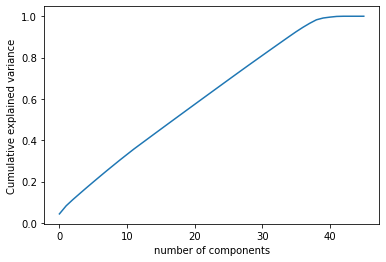

In [93]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train_pca)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [94]:
arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
list(zip(range(1,len(arr)), arr))

[(1, 4.32),
 (2, 8.26),
 (3, 11.29),
 (4, 14.149999999999999),
 (5, 16.979999999999997),
 (6, 19.759999999999998),
 (7, 22.509999999999998),
 (8, 25.229999999999997),
 (9, 27.9),
 (10, 30.56),
 (11, 33.14),
 (12, 35.71),
 (13, 38.13),
 (14, 40.550000000000004),
 (15, 42.970000000000006),
 (16, 45.38000000000001),
 (17, 47.790000000000006),
 (18, 50.190000000000005),
 (19, 52.59),
 (20, 54.980000000000004),
 (21, 57.370000000000005),
 (22, 59.760000000000005),
 (23, 62.14000000000001),
 (24, 64.52000000000001),
 (25, 66.9),
 (26, 69.28),
 (27, 71.65),
 (28, 74.02000000000001),
 (29, 76.37),
 (30, 78.7),
 (31, 81.03),
 (32, 83.35),
 (33, 85.66),
 (34, 87.97),
 (35, 90.27),
 (36, 92.53),
 (37, 94.64),
 (38, 96.58),
 (39, 98.28999999999999),
 (40, 99.14999999999999),
 (41, 99.58),
 (42, 99.92),
 (43, 100.01),
 (44, 100.01),
 (45, 100.01)]

### Observation
- Here we can see that almost 40 variables are needed for capturing atleast 99% of the variance in the training dataset. Hence we will use the same set of variables.

In [95]:
pca_10 = PCA(n_components=40)
X_train_pca = pca_10.fit_transform(X_train_pca)
X_test_pca = pca_10.transform(X_test_pca)

PCA is applied on the training and the test dataset. Our input features are now ready for the regression.

<a id=corr></a>
# Correlation Analysis
***
Correlation analysis is a method of statistical evaluation used to study the strength of a relationship between two or more, numerically measured, continuous variables. This analysis is useful when we need to check if there are possible connections between variables. We will utilize Heatmap for our analysis.

<a id=heatmap></a>
## Heatmap
***
A heatmap is a graphical representation of data that uses a system of color-coding to represent statistical relationship between different values.

Let's plot the relationship between the features of the **Feature selection** group first


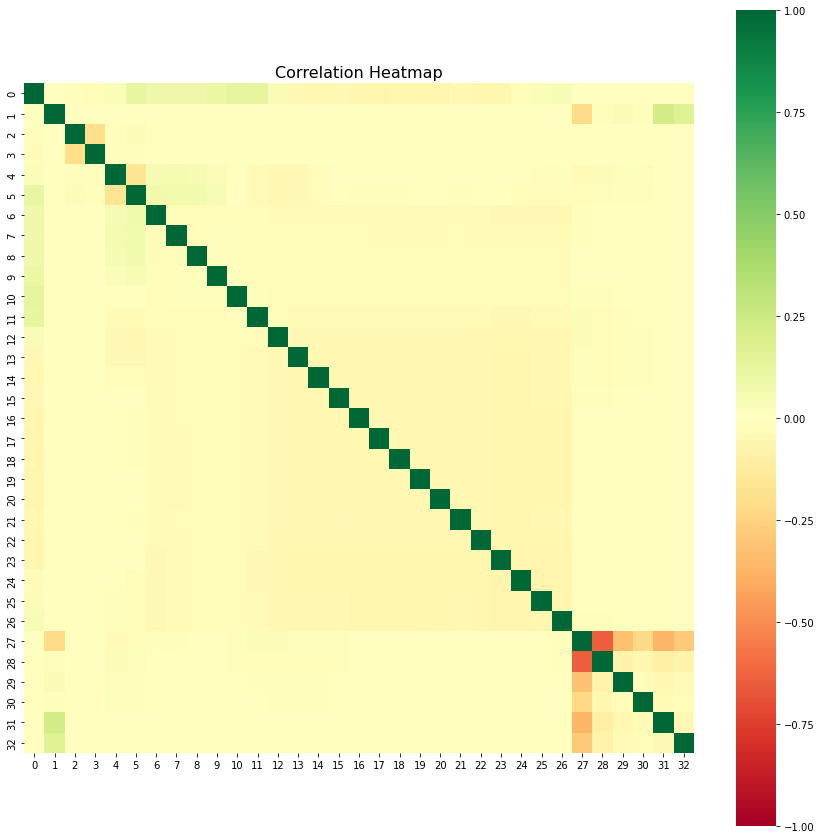

In [96]:
plt.figure(figsize=(15,15))
corr = pd.DataFrame(X_train_fs[:,1:]).corr()
corr.index = pd.DataFrame(X_train_fs[:,1:]).columns
sns.heatmap(corr, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

### Observations
 - Some combinations of features shows slight correlation but not above 0.5.
 - Some features are infact negatively correlated.
 - But most of the features shows no correlation. Which is a good thing.
 
 All in all, we have a very good pack of attributes to train our model. Let's move ahead.

Let's now plot the relationship between the features of the **Feature extraction** group.

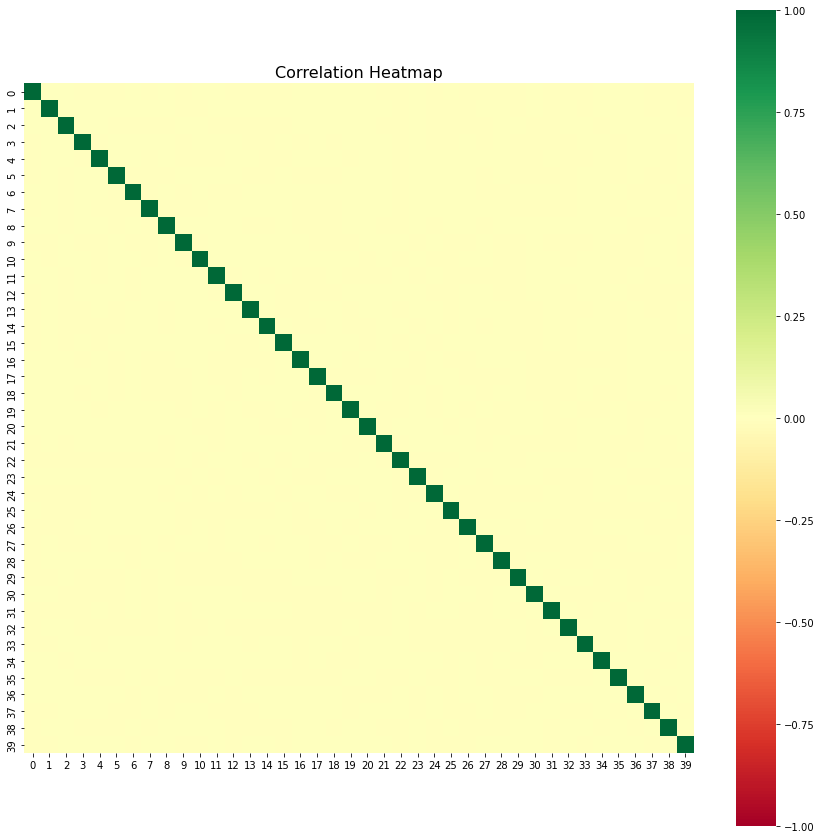

In [97]:
plt.figure(figsize=(15,15))
corr = pd.DataFrame(X_train_pca).corr()
corr.index = pd.DataFrame(X_train_pca).columns
sns.heatmap(corr, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

### Observations
 - All of the features shows **NO** correlation at all. Because feature extraction removes all collinearity.
 
Let's move on to the Model now.

<a id=model></a>
# Model
***
We need a model to train on our dataset to serve our purpose of prediciting the NYC taxi trip duration given the other features as training and test set. Since our dependent variable contains continous values so we will use regression technique to predict our output.

<a id=lin_reg></a>
## Multiple Linear Regression
***
It is used to explain the relationship between one continuous dependent variable and two or more independent variables. Let's proceed

<a id=train></a>
## Model training
***
We will first try with the default instantiation of the regressor object without using any generalization parameter. We will also **not perform any scaling** of the features because linear regression model takes care of that inherently. This is a plus point to use Linear regression model. It is quite fast to train even on very large datasets. So considering the size of our dataset this seems to be the correct approach as of now. Let's see how it performs.

<img src='http://www.sixthcents.net/images/macbook.gif'/>

In [98]:
#Linear regressor for the raw data
regressor = LinearRegression() 
regressor.fit(X_train,y_train) 

#Linear regressor for the Feature selection group
regressor1 = LinearRegression() 
regressor1.fit(X_train_fs,y_train_fs) 

#Linear regressor for the Feature extraction group
regressor2 = LinearRegression() 
regressor2.fit(X_train_pca,y_train_pca) 

LinearRegression()

### Interesting find:
 - It took **approx 1 second to train the model** on dataset of more than 1 million records.
 - It is evident that Linear regression model is **extremely fast** to train on the high dimension datasets consisting of even **millions** of records.
 - Linear regression object for the feature extraction group took less time to train on the input features.

<a id=predict></a>
## Model prediction
***
So now, our model has been fitted to the training set. It's time to predict the dependent variable. Let's do that now.

In [99]:
#Predict from the test features of raw data
y_pred = regressor.predict(X_test) 

#Predict from the test features of Feature Selection group
y_pred = regressor1.predict(X_test_fs) 

#Predict from the test features of Feature Extraction group
y_pred_pca = regressor2.predict(X_test_pca) 

<a id=evaluate></a>
## Model evaluation
***
We will evaluate our model's accuracy through two suggested metrics for the regression models. i.e. RMSE and variance score. Where RMSE of 0 and variance of 1 is considered as the best score for a prediction model.

In [100]:
#Evaluate the regressor on the raw data
print('RMSE score for the Multiple LR raw is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred))))
print('Variance score for the Multiple LR raw is : %.2f' % regressor.score(X_test, y_test))
print("\n")

#Evaluate the regressor on the Feature selection group
print('RMSE score for the Multiple LR FS is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred))))
print('Variance score for the Multiple LR FS is : %.2f' % regressor1.score(X_test_fs, y_test_fs))
print("\n")

#Evaluate the regressor on the Feature extraction group
print('RMSE score for the Multiple LR PCA is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_pca,y_pred_pca))))
print('Variance score for the Multiple LR PCA is : %.2f' % regressor2.score(X_test_pca, y_test_pca))

RMSE score for the Multiple LR raw is : 2749.869581017632
Variance score for the Multiple LR raw is : 0.07


RMSE score for the Multiple LR FS is : 2749.869581017632
Variance score for the Multiple LR FS is : 0.07


RMSE score for the Multiple LR PCA is : 2750.0010086255465
Variance score for the Multiple LR PCA is : 0.07


### Observations
 - Very poor **Root mean squared** value. 
 - And the low **variance score** which is also bad.
 - Both the models i.e. from the feature selection and the feature extraction group resulted quite bad in prediction.
 
 **Let's find out the reason of this behaviour:-**

In [101]:
X_train.shape

(1163047, 46)

In [102]:
#Find linear correlation of each feature with the target variable
from scipy.stats import pearsonr
df1 = pd.DataFrame(np.concatenate((X_train,y_train.reshape(len(y_train),1)),axis=1))
df1.columns = df1.columns.astype(str)

features = df1.iloc[:,:46].columns.tolist()
target = df1.iloc[:,46].name

correlations = {}
for f in features:
    data_temp = df1[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]
    
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
0 vs 46,0.18
1 vs 46,-0.05
3 vs 46,0.03
38 vs 46,-0.01
29 vs 46,0.01
20 vs 46,-0.01
30 vs 46,0.01
42 vs 46,0.01
8 vs 46,0.01
7 vs 46,0.01


### Observations
We can see that none of the feature is linearly correlated with the target variable **"46"**. That is why it is not a good model for the prediction of the trip duration. So let's move ahead and try the **random forest regressor**. We are not using decision tree regressor because the random forest will anyways consist of almost all its properties. Also, we will not use SVR because it takes too much time to train on this huge dataset even with the default settings. It seems to be not good with high dimensional dataset as well as for the huge instances.

<a id=rf_reg></a>
## Random Forest Regressor
***
A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting

### Model training
***
Now we will train the model on the filtered features. Our data has already been split so we will not split the data further.

#### Note:
We used **GridSearch** to tune the **hyperparameters** of random forest regressor to get the best possible test score. We tried various combination of the allowed hyper params values. _But any kind of combination could not produce significantly better results than the default settings. There can be many reasons for that and it totally depends on the type of data we have in hand. Therefore we will not show tuned regressor results here._

In [ ]:
#instantiate the object for the Random Forest Regressor with default params from raw data
regressor_rfraw = RandomForestRegressor(n_jobs=-1)

#instantiate the object for the Random Forest Regressor with default params for Feature Selection Group
regressor_rf = RandomForestRegressor(n_jobs=-1)

# #instantiate the object for the Random Forest Regressor with tuned hyper parameters for Feature Selection Group
# regressor_rf1 = RandomForestRegressor(n_estimators = 26,
#                                      max_depth = 22,
#                                      min_samples_split = 9,
#                                      n_jobs=-1)

#instantiate the object for the Random Forest Regressor for Feature Extraction Group
regressor_rf2 = RandomForestRegressor(n_jobs=-1)


#Train the object with default params for raw data
regressor_rfraw.fit(X_train,y_train)

#Train the object with default params for Feature Selection Group
regressor_rf.fit(X_train_fs,y_train_fs)

# #Train the object with tuned params for Feature Selection Group
# regressor_rf1.fit(X_train_fs,y_train_fs)

# #Train the object with default params for Feature Extraction Group
regressor_rf2.fit(X_train_pca,y_train_pca)

print("\n")

### Model prediction

In [ ]:
#Predict the output with object of default params for Feature Selection Group
y_pred_rfraw = regressor_rfraw.predict(X_test)

#Predict the output with object of default params for Feature Selection Group
y_pred_rf = regressor_rf.predict(X_test_fs)

# #Predict the output with object of hyper tuned params for Feature Selection Group
# y_pred_rf1 = regressor_rf1.predict(X_test_fs)

#Predict the output with object of PCA params for Feature Extraction Group
y_pred_rfpca = regressor_rf2.predict(X_test_pca)

print("\n")

### Model evaluation

In [ ]:
#Evaluate the model with default params for raw data
print('RMSE score for the RF regressor raw is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred_rfraw))))
print('RMSLE score for the RF regressor raw is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test,y_pred_rfraw))))
print('Variance score for the RF regressor raw is : %.2f' % regressor_rfraw.score(X_test, y_test))

print("\n")

#Evaluate the model with default params for Feature Selection Group
print('RMSE score for the RF regressor is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred_rf))))
print('RMSLE score for the RF regressor is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test_fs,y_pred_rf))))
print('Variance score for the RF regressor is : %.2f' % regressor_rf.score(X_test_fs, y_test_fs))

# print("\n")

# #Evaluate the model with tuned params for Feature Selection Group
# print('RMSE score for the RF regressor1 is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred_rf1))))
# print('RMSLE score for the RF regressor1 is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test_fs,y_pred_rf1))))
# print('Variance score for the RF regressor1 is : %.2f' % regressor_rf1.score(X_test_fs, y_test_fs))

print("\n")

#Evaluate the model with PCA params  for Feature Extraction Group
print('RMSE score for the RF regressor2 is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_pca, y_pred_rfpca))))
print('Variance score for the RF regressor2 is : %.2f' % regressor_rf2.score(X_test_pca, y_test_pca))

### Interesting find
- There is approx **200% improvement** on the RMSE score for the Random forest regressor over the Linear regressor of the feature selection group.
- Even the variance score is approx 1 which is a good score.
- RMSE score for the RF regressor of feature extraction group is still very bad along with the variance score.
- RMSE score for the feature selection group is more or less same as the raw data score. Sometimes the RMSE score for the raw data is better and vice versa. It fluctuates on every iteration and this is quite weird!

Let's see if we can improve this further with the most sought after algorigthm i.e. XGBoost!!

<a id=xgboost></a>
## XGBoost Regressor
***
XGBoost (Extreme Gradient Boosting) is an optimized distributed gradient boosting library. It uses gradient boosting (GBM) framework at core. It belongs to a family of boosting algorithms that convert weak learners into strong learners. A weak learner is one which is slightly better than random guessing.

'Boosting' here is a sequential process; i.e., trees are grown using the information from a previously grown tree one after the other. This process slowly learns from data and tries to improve its prediction in the subsequent iterations.

### Model training
***
We will train the model on the filtered features. Our data has already been split so we will not split the data further.

#### Note:
We used **GridSearch** to tune the **hyperparameters** of XGBoost regressor to get the best possible test score.  We will compare results from the default regressor and the tuned regressor.

In [ ]:
#instantiate the object for the XGBoost Regressor with default params for raw data
regressor_xgbraw = XGBRegressor(n_jobs=-1)

#instantiate the object for the XGBoost Regressor with default params for Feature Selection Group
regressor_xgb = XGBRegressor(n_jobs=-1)

#instantiate the object for the XGBoost Regressor with tuned hyper parameters for Feature Selection Group
regressor_xgb1 = XGBRegressor(n_estimators=300,
                            learning_rate=0.08,
                            gamma=0,
                            subsample=0.75,
                            colsample_bytree=1,
                            max_depth=7,
                            min_child_weight=4,
                            silent=1,
                           n_jobs=-1)

#instantiate the object for the XGBoost Regressor for Feature Extraction Group
regressor_xgb2 = XGBRegressor(n_jobs=-1)


#Train the object with default params for raw data
regressor_xgbraw.fit(X_train,y_train)

#Train the object with default params for Feature Selection Group
regressor_xgb.fit(X_train_fs,y_train_fs)

#Train the object with tuned params for Feature Selection Group
regressor_xgb1.fit(X_train_fs,y_train_fs)

#Train the object with default params for Feature Extraction Group
regressor_xgb2.fit(X_train_pca,y_train_pca)

print("\n")

### Model prediction

In [ ]:
#Predict the output with object of default params for raw data
y_pred_xgbraw = regressor_xgbraw.predict(X_test)

#Predict the output with object of default params for Feature Selection Group
y_pred_xgb = regressor_xgb.predict(X_test_fs)

#Predict the output with object of hyper tuned params for Feature Selection Group
y_pred_xgb1 = regressor_xgb1.predict(X_test_fs)

#Predict the output with object of PCA params for Feature Extraction Group
y_pred_xgb_pca = regressor_xgb2.predict(X_test_pca)

print("\n")

### Model Evaluation

In [ ]:
#Evaluate the model with default params for raw data
print('RMSE score for the XGBoost regressor raw is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred_xgbraw))))
# print('RMSLE score for the XGBoost regressor is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test,y_pred_xgb))))
print('Variance score for the XGBoost regressor raw is : %.2f' % regressor_xgbraw.score(X_test, y_test))

print("\n")

#Evaluate the model with default params for Feature Selection Group
print('RMSE score for the XGBoost regressor is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred_xgb))))
# print('RMSLE score for the XGBoost regressor is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test,y_pred_xgb))))
print('Variance score for the XGBoost regressor is : %.2f' % regressor_xgb.score(X_test_fs, y_test_fs))

print("\n")

#Evaluate the model with Tuned params for Feature Selection Group
print('RMSE score for the XGBoost regressor1 is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred_xgb1))))
# print('RMSLE score for the XGBoost regressor1 is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test_fs,y_pred_xgb1))))
print('Variance score for the XGBoost regressor1 is : %.2f' % regressor_xgb1.score(X_test_fs,y_test_fs))

print("\n")

#Evaluate the model with PCA params  for Feature Extraction Group
print('RMSE score for the XGBoost regressor2 is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_pca, y_pred_xgb_pca))))
print('Variance score for the XGBoost regressor2 is : %.2f' % regressor_xgb2.score(X_test_pca, y_test_pca))

### Observations
- There is a significant **improvement** in the RMSE score for the **tuned** XGBoost regressor over the Random forest regressor when trained on the feature selection group.
- But the performance of the **default** XGBoost regressor is quite **worse** than the default RF regressor on the same data.
- Also, the RMSE score on the raw data and feature selected data are same, which disproves the theory that it is always better to select the relevant features which are statistically important. As the data behaves differently in different models.
- Not to mention the fact that RMSE score for the XGBoost regressor of the feature extraction group is still bad along with the variance score. 

In [ ]:
#Comparing test results for the XGBoost and RF regressor
print("Total sum of difference between the actual and the predicted values for the RF regressor is : %d"%np.abs(np.sum(np.subtract(y_test,y_pred_rf))))
print("Total sum of difference between the actual and the predicted values for the tuned XGB regressor is : %d"%np.abs(np.sum(np.subtract(y_test,y_pred_xgb1))))

### General inference
- XGBoost proved to be much more efficient in predicting the output. But it takes much more time to train it over the large dataset wih more complexity as compared to the RF and Linear regression model but less time then the SVR.
- It didn't helped us much to generalize the model by tuning hyper parameters for the RF model as there is not much difference in the RMSE scores of the default model and the tuned model of the feature selection group infact both varies on every iteration and sometimes the tuned model gives poor results than the default model. Though we tried many possible alterations with GSCV but the tuning could not achieve a significant improvement over the default model which also depends on the contents of the dataset.
- Contrast to the RF regressor, XGBoost regressor prediction results were consistent on every iteration i.e. for each param configuration the results were the same.
- Feature extraction didn't helped in anyway to improve the RMSE score with any of the regressor models. This shows us that the feature extraction is somewhat not a good technique to preprocess the data before feeding it into the regressor models for the continous target value prediction. Whereas it also depends on the type and features of data that how it behaves with the model.

<a id=curve></a>
## Learning curves
***
Learning curves constitute a great tool to diagnose bias and variance in any supervised learning algorithm. It shows how error changes as the training set size increases. We'll use the learning_curve() [function](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html) from the scikit-learn library to generate a learning curve for the regression model. There's no need to put aside a validation set because learning_curve() will take care of that and that's why we will plot the learning curve over whole dataset.

In [ ]:
#Define a function to plot learning curve.
def learning_curves(estimator, title, features, target, train_sizes, cv, n_jobs=-1):
    plt.figure(figsize = (14,5))
    train_sizes, train_scores, validation_scores = learning_curve(estimator, features, target, train_sizes = train_sizes, cv = cv, scoring = 'neg_mean_squared_error',  n_jobs=n_jobs)
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)
    
    plt.grid()
    
    plt.plot(train_sizes, train_scores_mean,'o-', color="r", label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean,'o-', color="g", label = 'Validation error')

    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    
    title = 'Learning curves for a ' + title + ' model'
    plt.title(title, fontsize = 18, loc='left')
    
    plt.legend(loc="best")
    
    return plt

# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=4)

# Plot learning curve for the RF Regressor
title = "Random Forest Regressor"

# Call learning curve with all dataset i.e. traininig and test combined because CV will take of data split.
learning_curves(regressor_rf, title, X_opt,Y, train_sizes=np.linspace(.1, 1.0, 5), cv=cv, n_jobs=-1)

#Plot learning curve for the XGBoost Regressor
title = "XGBoost Regressor"

# Call learning curve on less number of estimators than the tuned estimator because it took too much time for the compilation.
learning_curves(XGBRegressor(n_estimators=111,
                            learning_rate=0.08,
                            gamma=0,
                            subsample=0.75,
                            colsample_bytree=1,
                            max_depth=7,
                            min_child_weight=4,
                            silent=1), title, X_opt,Y, train_sizes=np.linspace(.1, 1.0, 5), cv=cv, n_jobs=-1)

plt.show()

### Observations:
- We can observe that both the models shows somewhat similar learning rate but with visible differences in error rates. 
- RF training curve initially starts high but later on improves as the training size increases and then seems to plateaud by the end.
- XGBoost training curve on the other hand starts quite low and further improves with the increase in the training size and it too plateau towards the end.
- Validation curve seems to show similar trend in both the models i.e. starts very high but improves with the training size with some differences in error rate i.e. XGBoost curve learning is quite fast and more accurate as compared to the RF one.
- Both the models seems to suffer from **high variance** since the training curve error is very less in both the models.
- The large gap at the end also indicates that the model suffers from quite a **low bias** i.e. overfitting the training data.
- Also, both the model's still has potential to decrease and converge towards the training curve by the end.

**At this point, here are a few things we could do to improve our model:**

1. Add more training instances to improve validation curve in the XGBoost model.
2. Increase the regularization for the learning algorithm. This should decrease the variance and increase the bias towards the validation curve.
3. Reduce the numbers of features in the training data that we currently use. The algorithm will still fit the training data very well, but due to the decreased number of features, it will build less complex models. This should increase the bias and decrease the variance.